# tSNE and UMAP

This notebook was used to visualize the structure of the kaggle and OASIS datasets using t-Distributed Stochastic Neighbor Embedding (t-SNE) and Uniform Manifold Approximation and Projection (UMAP). 

# Loading Packages

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
!pip install umap-learn[plot]
!pip install holoviews
!pip install -U ipykernel
import umap
import umap.plot
import math
import numpy as np
import os
from zipfile import ZipFile
import PIL
from PIL import Image
from numpy import asarray
import glob
import warnings
from sklearn.manifold import TSNE
warnings.filterwarnings("ignore", category=UserWarning)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Loading and preparing data - kaggle dataset
> https://www.kaggle.com/datasets/sachinkumar413/alzheimer-mri-dataset

In [ ]:
# mounting google drive
from google.colab import drive
drive.mount('/content/drive/')

# downloads kaggle dataset and unzips zip file from drive
os.environ['KAGGLE_CONFIG_DIR'] = "/content"
# !kaggle datasets download -d sachinkumar413/alzheimer-mri-dataset
file_name = 'drive/MyDrive/Extracurriculars/InspiritAI/Deniz Yilmaz/Data/Old MRI Data/alzheimer-mri-dataset.zip'
with ZipFile(file_name, 'r') as zipfile:
    zipfile.extractall()

# creates label list and image list
label_dirs = glob.glob("/content/Dataset/*")
image_list = []

# puts images in image_list
for label_dir in label_dirs:
  label = label_dir.split("/")[3]
  for file in glob.glob(label_dir + "/*.jpg"):
    image = Image.open(file).resize((150,150)) 
    numpydata = asarray(image)
    image_item = np.array([label, file, numpydata])
    image_list.append(image_item)

# converts image_list to numpy array
image_array = np.asarray(image_list)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# normalization function
def normalize_one_image(image):
  return((image - np.min(image)) / (np.max(image) - np.min(image)))

# label conversion function
def label_to_number(label):
  if label == "Very_Mild_Demented":
    return 1
  if label == "Moderate_Demented":
    return 3
  if label == "Mild_Demented":
    return 2
  if label == "Non_Demented":
    return 0

  return -1

# creates normalized_image_array and label_array
normalized_image_array = []
label_array = []

# adds normalized images to normalized_image_array and new labels to label_array
for item in image_array:
  img = item[2]
  img = normalize_one_image(img)
  img = img.flatten()
  label = label_to_number(item[0])
  normalized_image_array.append(img)
  label_array.append(label)

## UMAP

In [ ]:
# prepares df
df = pd.DataFrame(normalized_image_array)
df['Diagnosis'] = label_array

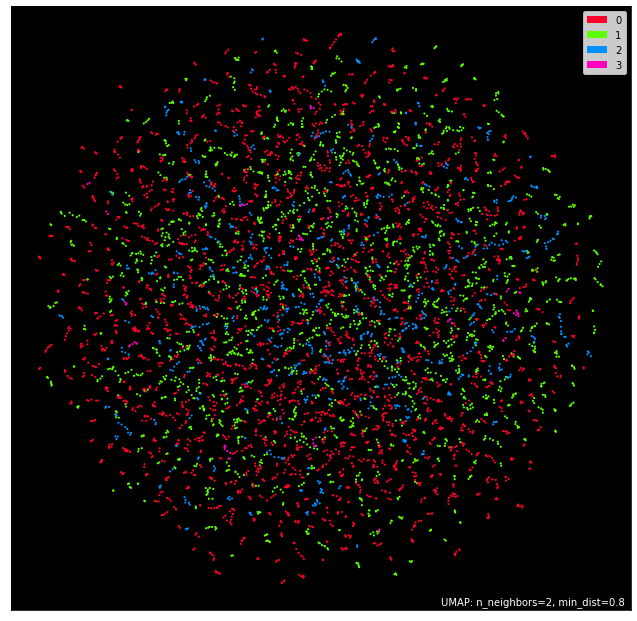

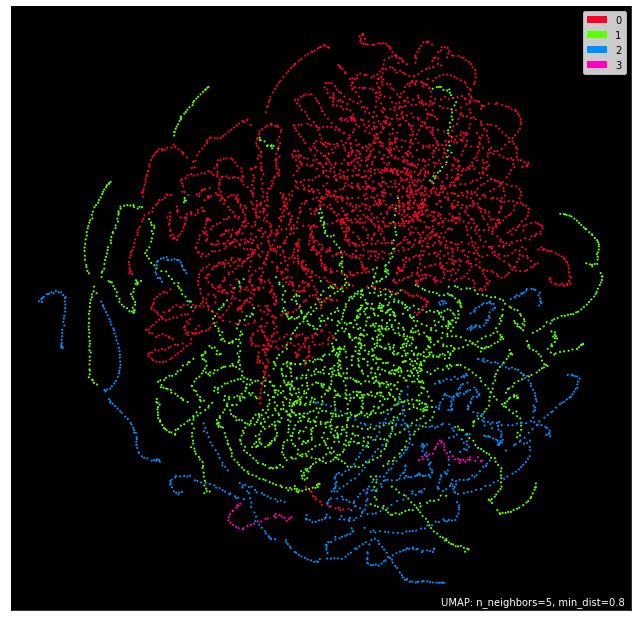

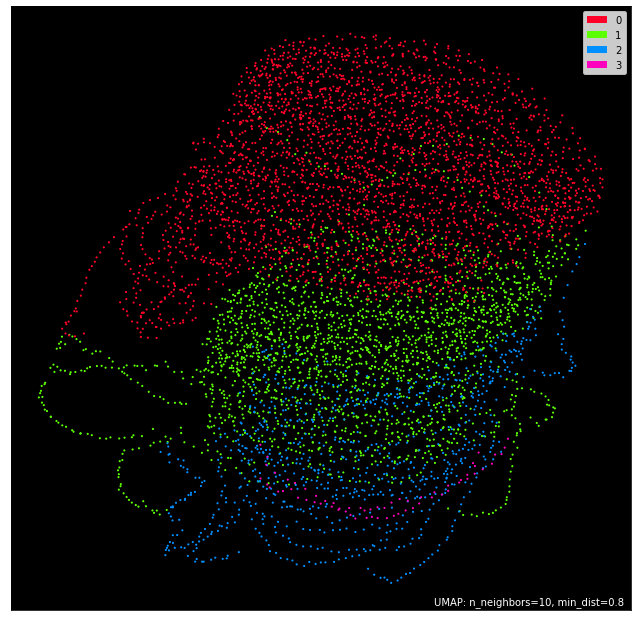

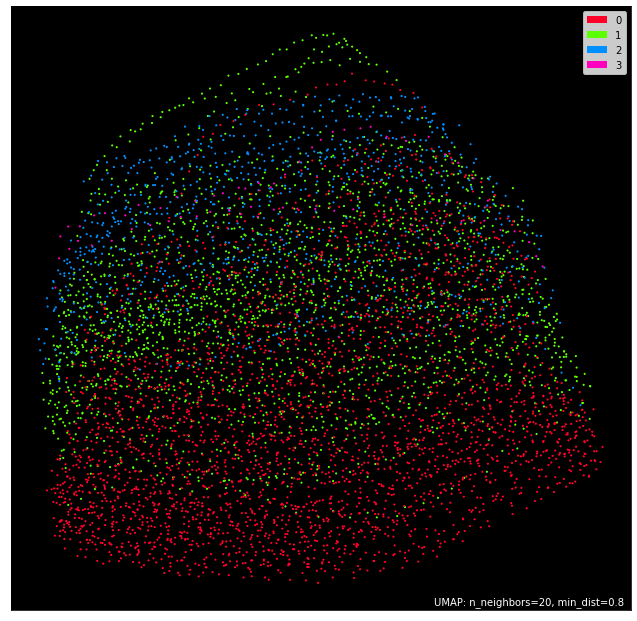

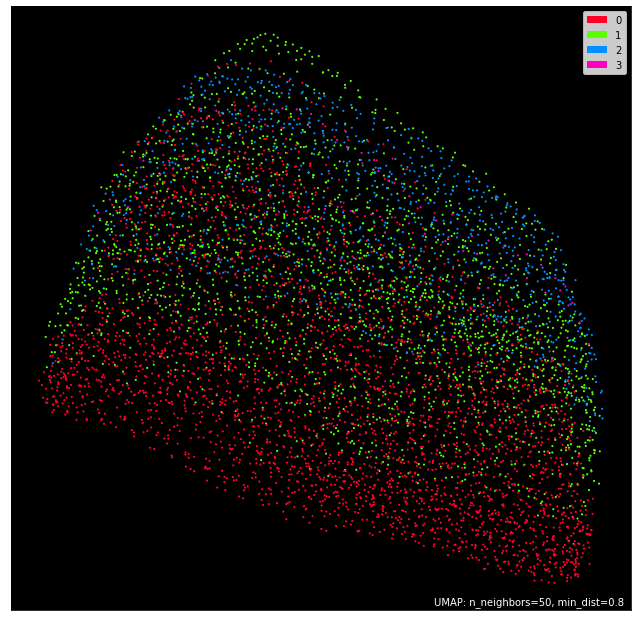

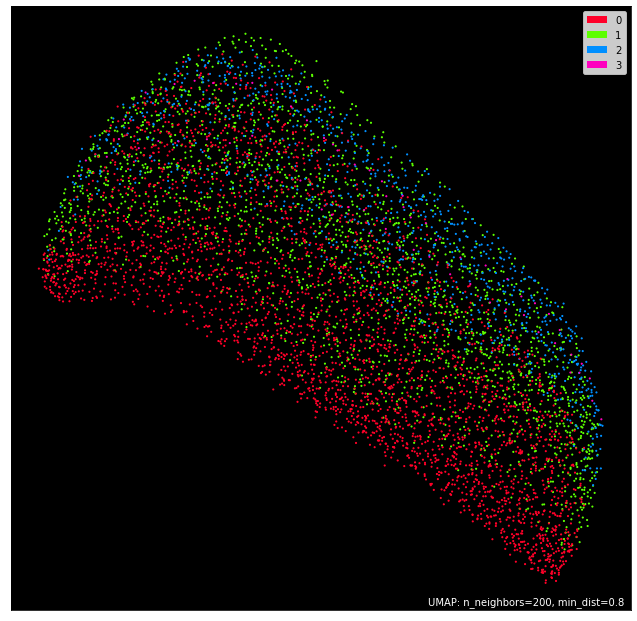

In [ ]:
# umap function
def draw_umap(neighbors):
  mapper = umap.UMAP(n_neighbors=neighbor, min_dist = 0.8).fit(df)
  umap.plot.points(mapper, labels=df.Diagnosis, color_key_cmap='gist_rainbow', background='black')

neighbors = [2,5,10,20,50,200]

# experimenting with different n_neighobrs parameter
for neighbor in neighbors:
  draw_umap(neighbor)

## tSNE

In [ ]:
# prepares x and y for tsne
x = df.copy
y = df.Diagnosis

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/skle

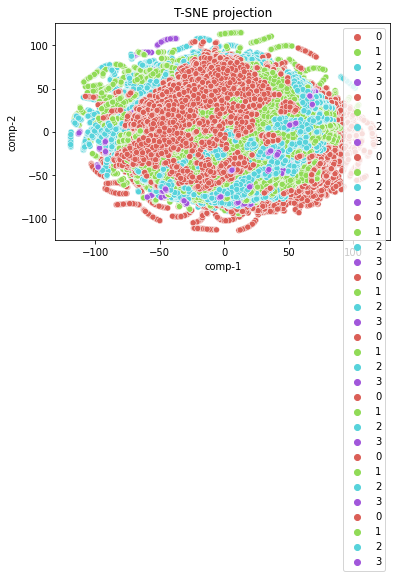

In [ ]:
# tSNE function
def draw_tsne(perplexity_value, dataframe):
  tsne = TSNE(n_components=2, perplexity = perplexity_value, verbose=0, random_state=123)
  z = tsne.fit_transform(dataframe) 
  df = pd.DataFrame()
  df["y"] = y
  df["comp-1"] = z[:,0]
  df["comp-2"] = z[:,1]

  sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                  palette=sns.color_palette("hls", 4),
                  data=df).set(title="T-SNE projection") 

draw_tsne(5, df)

# Loading and preparing data - oasis dataset
> https://www.oasis-brains.org/#data

In [ ]:
def label_converter(label):
  if label == 0.5:
    label = 1
  elif label == 1:
    label = 2
  elif label == 2:
    label =3
  
  # 0: non-demented
  # 1: very mild demented
  # 2: mild demented
  # 3: moderate demented
  
  return label

oasis_dataset_dir = 'drive/MyDrive/Extracurriculars/InspiritAI/Deniz Yilmaz/Data/oasis_dataset'

# creates label list and image list
subject_dirs = glob.glob(oasis_dataset_dir + "/OAS1*")
oasis_normalized_image_array = []
oasis_label_array = []

oasis_df = pd.read_csv(oasis_dataset_dir + "/oasis_cross-sectional_filtered.csv")

# puts stuff in image_list
for subject_dir in subject_dirs:
  # print(subject_dir)
  subject_id = subject_dir.split("/")[7]
  # print(subject_id)
  label = oasis_df.loc[oasis_df['ID'] == subject_id]['CDR'].item()
  # print(label)
  label = label_converter(label)
  for file in glob.glob(subject_dir + "/PROCESSED/MPRAGE/T88_111/*masked_gfc_tra_90.gif"):
    image = Image.open(file).resize((64,64))
    image = image.rotate(180)
    image = image.convert('L') # convert RGB to gray
    image = asarray(image)
    image = normalize_one_image(image)
    image = image.flatten()
    # image = black_and_white(image)
    oasis_normalized_image_array.append(image)
    oasis_label_array.append(label) 

# creating binary labels
oasis_label_binary0 = oasis_label_array.copy()

for idx in range(len(oasis_label_binary0)):
  if oasis_label_binary0[idx] == 3 or oasis_label_binary0[idx] == 2:
    oasis_label_binary0[idx] = 1

## UMAP

In [ ]:
# prepares data
df = pd.DataFrame(oasis_normalized_image_array)
df['Diagnosis'] = oasis_label_array

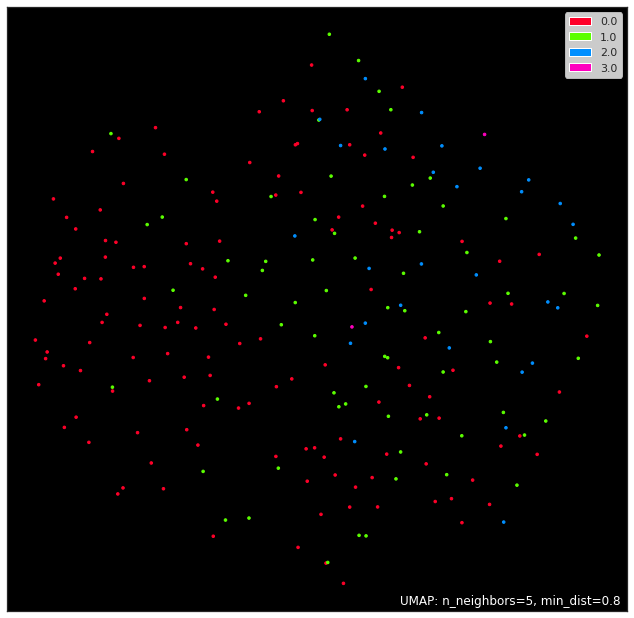

In [ ]:
draw_umap(5, df)

## tSNE

In [ ]:
# prepares x and y for tSNE
x = df.copy
y = df.Diagnosis

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


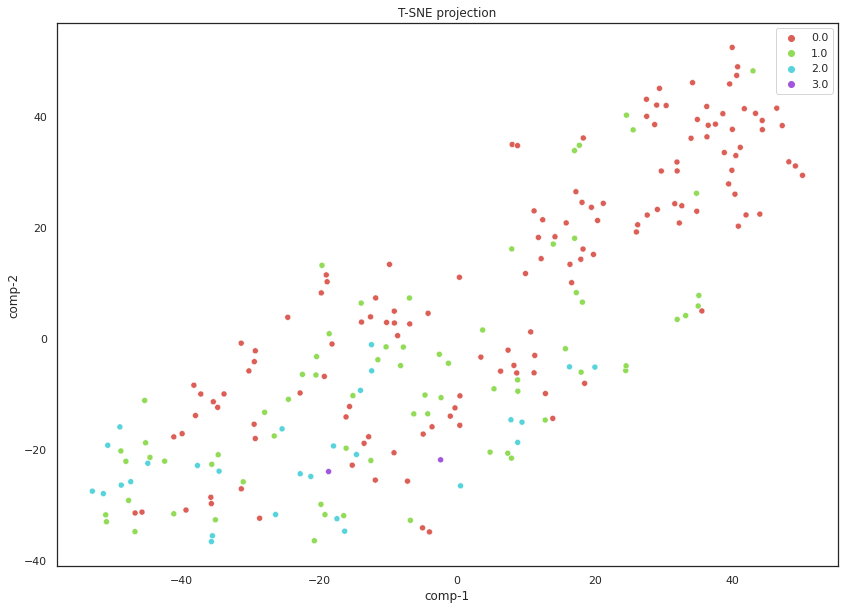

In [ ]:
draw_tsne(5, df)